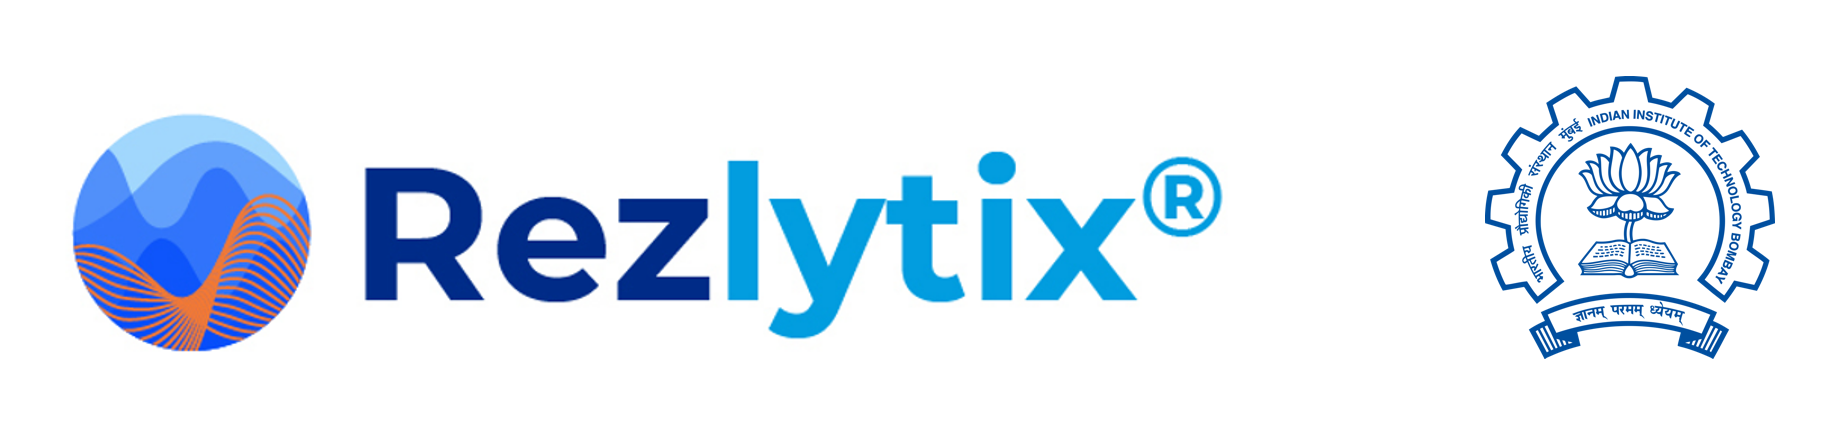

## Notebook overview

* Seismic Well ties in python
* Using ML to impute missing log data 




# Seismic Well Ties & Applying ML to impute missing log data


-----

In [ ]:
##### Applicable only if you are running this notebook on Colab. Disble otherwise.
##### Mount your google drive to this notebook. It will require some permissions.

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Define base working directory for this session. Same as the one created earlier.
import os
# base_dir = "/content/drive/My Drive/<Your_folder_name>"     # Please change path / folder name as required. 
base_dir = "/content/drive/My Drive/Colab Notebooks/IITB_Workshop"
#base_dir='/content/drive/MyDrive/Data/SAQI_Volve/volve-machine-learning'
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

if not os.path.isdir(base_dir + "/loaded"):
    os.mkdir(base_dir + "/loaded")

os.chdir(base_dir)

**Please ensure that the sample data folder (workshop_data) that we have provided is inside this base directory.**

### Required libraries

Let's first get all the required libraries.
Since some of these have fairly specific / limited usage, they are usually not part of the standard set of libraries already installed within Colab.

In [ ]:
# Imports for JupyterLite
%pip install -q ipywidgets

In [ ]:
# Let's first install a few uncommon libraries to this environment.
!pip install lasio
!pip install wget
!pip install segyio
!pip install segysak
!pip install pydantic

Other common libraries you will need in this notebook. Please install them if you don't already have them. These come pre-installed in Colab.

* numpy
* scipy
* pandas
* matplotlib
* seaborn
* plotly

In [ ]:
# Scientific and data analysis libraries

import pandas as pd
import numpy as np
import numpy.linalg as LA
from numpy.polynomial.polynomial import polyfit
import xarray as xr
import math
from math import sqrt

import scipy
from scipy import interpolate as interp
from scipy.interpolate import CloughTocher2DInterpolator, griddata
from scipy import signal
from scipy.signal import savgol_filter, correlate, coherence, hilbert, periodogram, welch, butter, lfilter
from scipy.spatial import KDTree, cKDTree, distance
from scipy.fftpack import ifft,fftshift,fft
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr
from functools import reduce

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.transforms as transforms
from matplotlib import gridspec
from matplotlib.pyplot import cm
from matplotlib.cbook import flatten
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as ipyw

# Typesafe coding
from pydantic import BaseModel, Field
from typing import Any, Optional,List, Union
from typing import Dict, Union
from typing_extensions import Annotated, Literal

# Generic libraries
import os
import time
import shutil
from shutil import copyfile
import warnings

warnings.filterwarnings("ignore")

mpl.rc('font', size=20)
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.3f}'.format

# Use if you want to remove limits on the max no. of rows visible in a dataframe
# pd.set_option('display.max_rows', None)

------

## Seismic well ties

Well-to-seismic ties is an extremely important step within seismic interpretation and inversion.<br> 

It allows us to relate features from the well data such as formation tops, the position of a fault, where we have core intervals in the section to peaks and troughs on the seismic line that passes through the well location or close to the well location.<br>

While this is a standard within most industry standard interpretation softwares, let's dive into how you would perform this yourself using Python.<br><br>
The steps involved are as follows:
1. Data preparation
2. Depth to Time domain conversion
3. Extract seismic traces at well location
4. Wavelet Extraction



### Data preparation

We shall use the csvs in the "xyt" directory to obtain the time-depth relationship at regular depth intervals of the well. The times refer to seismic two-way traveltimes in milliseconds. <br>
The entries also include the coordinates of the well at each interval. This indicates that the wells are deviated.

In [ ]:
base_dir='/content/drive/MyDrive/Data/SAQI_Volve/volve-machine-learning'

In [ ]:
# Wells under consideration
wells_list  = ['15_9-F-11A',  '15_9-F-1A', '15_9-F-1B',  '15_9-F-11T2']

In [ ]:
well_name=''

In [ ]:
# Read in the time-depth data "
df_xyt = pd.read_csv(base_dir + '/workshop_data/xyt/' + well_name + '.csv')
df_xyt = df_xyt[['Depth(m)', 'TWT(ms)', 'X(m)', 'Y(m)']]
df_xyt

In [ ]:
# Function to prepare data for seaimic well ties
def sw_tie_well_data_prep(df=None, df_xyt=None):
    
    # Obtain the interpolated TWT, X & Y coordinates from the time-depth dataframe created earlier.
    df['TWT(ms)']=np.interp(df['DEPTH'],df_xyt['Depth(m)'],df_xyt['TWT(ms)'])
    df['X(m)']=np.interp(df['DEPTH'],df_xyt['Depth(m)'],df_xyt['X(m)'])
    df['Y(m)']=np.interp(df['DEPTH'],df_xyt['Depth(m)'],df_xyt['Y(m)'])

    #unit convert to µs/m (SI units)
    df['DT(µs/m)'] = df['DT'] / 0.3048 

    #unit convert to kg/m3 (SI units)
    df['RHOB(kg/m3)'] = df['RHOB'] * 1000  

    # Sonic velocity calculation
    #(unit: m/s)
    df['Vsonic(m/s)'] = 1e6/np.array(df['DT(µs/m)'])

    # Acoustic Impedance calculation
    #(unit: kg/m2.s)
    df['AI(kg/m2.s)'] = np.array(df['Vsonic(m/s)']) * np.array(df['RHOB(kg/m3)']) 


    return df


In [ ]:
def load_las_xr_to_df(well_name: str, 
                      las_xr_dir: str):
    """
        Function to load well xarrays to a dataframe

        Args:
            well_name (str): the name of the well
            las_xr_dir (str): the location of the xarray files

        Returns:
            dataframe: the well data.
    """
    xr_list = os.listdir(las_xr_dir)                                    # Creating a list of all available xarray files
    file_to_load = [file for file in xr_list if well_name in file]      # Identify the file for the current well

    well_xr = xr.open_dataset(las_xr_dir + file_to_load[0])
    well_df = well_xr.to_dataframe()
    well_df.reset_index(inplace=True)
    return well_df

In [ ]:
#well_ds_dff = load_las_xr_to_df(

In [ ]:
#well_ds_dff=sw_tie_well_data_prep(

### Depth  to time domain conversion

In [ ]:
def data_tdom_resample(df=None,features=None,well_sample_rate_twt=None):
    df_dict=dict()
    df_dict['TWT(ms)']= np.arange(df['TWT(ms)'].min(),df['TWT(ms)'].max(),well_sample_rate_twt)
    
    xnew=np.arange(df['TWT(ms)'].min(),df['TWT(ms)'].max(),well_sample_rate_twt)
    
    for a in range(len(features)):
      x=df['TWT(ms)']
      y=np.array(df[features[a]])
      f=np.interp(xnew,x,y)
      df_dict[features[a]]=f
    
    dfD=pd.DataFrame.from_dict(df_dict)
    
    #Reflectivity (Rc) calculation
    Imp = dfD['AI(kg/m2.s)'].values
    Rc=[]
    for i in range(len(Imp)-1):
        Rc.append((Imp[i+1]-Imp[i])/(Imp[i]+Imp[i+1]))

    # to adjust vector size copy the last element to the tail
    Rc.append(Rc[-1])

    # Let's add Rc into the existing well dataframe as a new column
    dfD['Rc'] = pd.Series(Rc, index=dfD.index)
    dfD['DEPTH']=np.interp(dfD['TWT(ms)'],df['TWT(ms)'],df['DEPTH'])
    dfD.reset_index(inplace=True,drop=True)
    return dfD

In [ ]:
dt = 0.2  #sampling interval in milliseconds
features=['DEPTH','DT(µs/m)','RHOB(kg/m3)', 'Vsonic(m/s)', 'AI(kg/m2.s)', 'TWT(ms)', 'X(m)','Y(m)']

#well_ds_dff_tdom=data_tdom_resample(

#### Visualize the well on a basemap

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def basemap_well_plot(df_seis_header=None,df_xyt=None):
  fig, ax = plt.subplots(figsize=(10,10))
  sns.scatterplot(x=np.array(df_seis_header['cdp_x']),y=np.array(df_seis_header['cdp_y']))
  plt.plot(df_xyt['X(m)'],df_xyt['Y(m)'],color='red')
  ax.minorticks_on()
  ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
  ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.ticklabel_format(useOffset=False, style='plain')
  plt.title('BaseMap',weight='bold', fontsize=20)
  plt.show()

In [ ]:
# Load the survey file that was created during SEG-Y loading. Please update the file name as required
df_seis_header = pd.read_csv(base_dir + '/loaded/seis_xr_sample_survey.csv')

In [ ]:
#basemap_well_plot(

In [ ]:
df_seis_header.head()

### Extract seismic trace(s) at well location

In [ ]:
# Reload the xarray file that had been created during the Data Loading session. Please update path / filename as required.
seisnc_3d = xr.open_dataset(base_dir + '/loaded/seis_xr_sample.nc')

In [ ]:
#nearest_seismic Trace
from scipy.spatial import KDTree
def nearest_seismic_trace(df_seis_header=None,df=None,seisnc_3d=None):
  tree = KDTree(np.c_[np.array(df_seis_header['CDP_X']), np.array(df_seis_header['CDP_Y'])])
  X_=df['X(m)'].mean()
  Y_=df['Y(m)'].mean()
  node=(X_,Y_)
  H1,H=tree.query([node], k=1)
  df_seis_headerWell=df_seis_header.iloc[H]
  ss=seisnc_3d.sel(iline=list(df_seis_headerWell['INLINE_3D'])[0])
  ss=ss.sel(xline=list(df_seis_headerWell['CROSSLINE_3D'])[0])
  #vertical seismic trace
  df['Seismic']=np.interp(np.array(df['TWT(ms)']),np.array(ss.twt.data),np.array(ss.data.data))
  return df,df_seis_headerWell

In [ ]:
#well_ds_dff_tdom,df_seis_headerWell=nearest_seismic_trace(

### Wavelet estimation

####https://wiki.seg.org/wiki/Dictionary:Ricker_wavelet

In [ ]:
# Function to obtain ricker wavelet
def ricker(f=30,length=0.2, dt=0.002,p=0):
    t = np.arange(-length/2, (length-dt)/2, dt)
    pi=np.pi
    s = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    phase=p*( pi/180)
    h=hilbert(s)
    s1= math.cos(phase)*h.real - math.sin(phase)*h.imag 
    rw = s1;
    return t,rw

In [ ]:
# Visualization function for wavelet
def wavelet_visual(DFb2Wav,well_SampleRate_ms):
  fig = plt.figure(figsize=(40,10))
  gs = gridspec.GridSpec(1,2)
  ax0 = fig.add_subplot(gs[0])
  ax0.plot(DFb2Wav['Time'],DFb2Wav['Wave Amplitude'])
  ax0.set_xlabel("Time(s)")
  ax0.set_ylabel("Amplitude")
  ax0.grid(True)
  ax0.set_xlim(-0.075,0.075)
  ax0.margins(x=0)
  Y1= np.fft.fft(np.array(DFb2Wav['Wave Amplitude']))
  freq = np.fft.fftfreq(len(np.array(DFb2Wav['Wave Amplitude'])), well_SampleRate_ms/1000)
  dfFt=pd.DataFrame(freq,columns=['Freq'])
  dfFt['Amplitude']=np.abs(Y1)/len(np.array(DFb2Wav['Wave Amplitude']))
  dfFt=dfFt[dfFt['Freq']>=0]
  ax1 = fig.add_subplot(gs[1])
  ax1.plot(dfFt['Freq'],dfFt['Amplitude'])
  ax1.set_ylabel('Amplitude')
  ax1.set_xlabel('Frequency')
  ax1.axis(xmin = 0)
  ax1.axis(ymin = 0)
  ax1.set_xlim(0,250)
  ax1.grid(True)
  plt.show()

In [ ]:
# Create ricker wavelet
f=15          #wavelet dominant frequency
length=0.15   #Wavelet vector length
phase=0       #phase
#t0, w = ricker (


df_b_to_wav=pd.DataFrame()
#df_b_to_wav['Wave Amplitude']=w
#df_b_to_wav['Time']=t0

#well_ds_dff_tdom['Synthetic'] = np.convolve( np.array(well_ds_dff_tdom['Rc']),w, mode='same')
#data_Syn=well_ds_dff_tdom
#a=np.array(data_Syn['Synthetic'])
#b=np.array(data_Syn['Seismic'])
#corr, _ = pearsonr(a,b)
#print('Correlation SW Tie Full Well '+str(well_name) +' : '+ str(np.round(corr,2)))


In [ ]:
#wavelet_visual(df_b_to_wav,dt)

### 1d visualization

In [ ]:
def sw_tie_plot_1d(df=None):
  fig, axs = plt.subplots(1, 6, figsize = (14,10))
  fig.subplots_adjust(left=0.05, bottom=0.05, right=0.975, top=0.7, wspace=0.2, hspace=0.2)
  m=0
  # -----------------------------------------------------------------------------------
  axs[m].plot( df['DT(µs/m)'], df['TWT(ms)'],'c', alpha=0.8)
  axs[m].set_title('DT ', style = 'normal')
  axs[m].set_xlabel( r'$\mu s/m $', fontsize = '12')
  axs[m].invert_yaxis()
  axs[m].grid()
  plt.setp(axs[m].get_yticklabels(), visible=True)
  m=m+1
  # -----------------------------------------------------------------------------------
  axs[m].plot( df['RHOB(kg/m3)'], df['TWT(ms)'],'r', alpha=0.6)
  axs[m].set_xlabel('$kg/cc$', fontsize = '12')
  axs[m].set_title('RHOB ', style = 'normal')
  axs[m].invert_yaxis()
  axs[m].grid()
  plt.setp(axs[m].get_yticklabels(), visible=False)
  m=m+1
  # -----------------------------------------------------------------------------------
  axs[m].plot( df['AI(kg/m2.s)'], df['TWT(ms)'],'k', alpha=0.8)
  axs[m].set_title('AI(kg/m2.s)', style = 'normal')
  axs[m].set_xlabel( r'$kg/m^2s^2$', fontsize = '12')
  axs[m].invert_yaxis()
  axs[m].grid()
  plt.setp(axs[m].get_yticklabels(), visible=False)
  m=m+1
  # -----------------------------------------------------------------------------------
  axs[m].plot( df['Rc'], df['TWT(ms)'],'k', alpha=0.8)
  axs[m].set_title('Reflection', style = 'normal')
  axs[m].set_xlabel('fraction' , fontsize = '12')
  axs[m].invert_yaxis()
  plt.setp(axs[m].get_yticklabels(), visible=False)
  axs[m].grid()
  m=m+1
  # -----------------------------------------------------------------------------------track5------------
  df['Synthetic']=(df['Synthetic']-df['Synthetic'].mean())/df['Synthetic'].std()
  for p in range(0,10,2):
    axs[m].plot( df['Synthetic']+p, df['TWT(ms)'] ,'b')
    axs[m].fill_betweenx(df['TWT(ms)'], np.array(df['Synthetic'])+p, p,  np.array(df['Synthetic']) > 0,  color='b')
  axs[m].set_title('Synthetic', style = 'normal')
  plt.setp(axs[m].get_yticklabels(), visible=False)
  axs[m].set_xticks([])
  axs[m].invert_yaxis()
  axs[m].grid()
  m=m+1
  # -----------------------------------------------------------------------------------track6------------
  df['Seismic']=(df['Seismic']-df['Seismic'].mean())/df['Seismic'].std()
  for p in range(0,10,2):
    axs[m].plot( df['Seismic']+p, df['TWT(ms)'] ,'r')
    axs[m].fill_betweenx(df['TWT(ms)'], np.array(df['Seismic'])+p, p,  np.array(df['Seismic']) > 0,  color='r')
  axs[m].set_title('Seismic', style = 'normal')
  axs[m].invert_yaxis()
  axs[m].set_xticks([])
  axs[m].grid()
  plt.setp(axs[m].get_yticklabels(), visible=False)
  plt.show()

In [ ]:
#sw_tie_plot_1d(df=well_ds_dff_tdom)

### 2d visualization

In [ ]:
def sw_tie_2d(df=None,seisnc=None,df_seis_headerWell=None,vm_percen=99,plot_direction='iline'):
  if plot_direction=='iline':
    other_direction='xline'
    ss=seisnc.sel(iline=list(df_seis_headerWell[plot_direction])[0])
    title='seismic_iline_'+str(list(df_seis_headerWell[plot_direction])[0])
    extent=[np.min(ss.xline.data),np.max(ss.xline.data),np.max(ss.twt.data),np.min(ss.twt.data)]
  elif plot_direction=='xline':
    other_direction='iline'
    ss=seisnc.sel(xline=list(df_seis_headerWell[plot_direction])[0])
    title='seismic_xline_'+str(list(df_seis_headerWell[plot_direction])[0])
    extent=[np.min(ss.iline.data),np.max(ss.iline.data),np.max(ss.twt.data),np.min(ss.twt.data)]
 
  dfseis=pd.DataFrame(ss.data.data).T
  twt_resample=np.arange(df['TWT(ms)'].min(),df['TWT(ms)'].max(),ss.sample_rate)
  syn=signal.resample(np.array(df['Synthetic']),twt_resample.shape[0])
  f3 = plt.figure(figsize=[16,12])
  plot=plt.imshow(dfseis,aspect='auto',cmap='gray_r',interpolation='bilinear',vmin=-np.nanpercentile(dfseis,vm_percen),vmax=np.nanpercentile(dfseis,vm_percen),extent=extent)
  plt.title(title)
  plt.xlabel(other_direction)
  plt.ylabel('twt')
  gain_synth =10
  plt.axvline(x=list(df_seis_headerWell[other_direction])[0], color='k', label='axvline - full height')
  plt.plot(syn*gain_synth+list(df_seis_headerWell[other_direction])[0],twt_resample , 'k')
  plt.fill_betweenx(twt_resample,syn*gain_synth+list(df_seis_headerWell[other_direction])[0],  list(df_seis_headerWell[other_direction])[0], 
                   syn*gain_synth+list(df_seis_headerWell[other_direction])[0] > list(df_seis_headerWell[other_direction])[0],
                  color = 'k', alpha = 0.5)
  plt.ylim(df['TWT(ms)'].max()+100,df['TWT(ms)'].min()-100)
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  f3.colorbar(plot, cax=cax, orientation='vertical')
  plt.show()



In [ ]:
#sw_tie_2d(plot_direction='iline')

In [ ]:
#sw_tie_2d(plot_direction='xline')

## ML applied: Prediction of sonic logs

### The Problem Statement


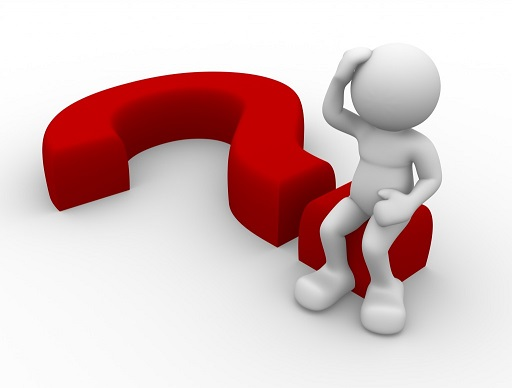

There are several instances when both Compressional sonic (DTC) and shear sonic (DTS) logs are not acquired simultaneously, due to financial constraints, lack of equipment, etc. <br>It may also so happen that the logs are missing for a certain depth range.

Under such circumstances, machine learning techniques can be effectively used to predict DTC and DTS logs to improve subsurface characterization.<br><br>

The goal of this exercise is to develop data-driven models by processing “easy-to-acquire” conventional logs from wells and use the models to predict synthetic compressional and shear travel-time logs.

**ML workflow life-cycle**

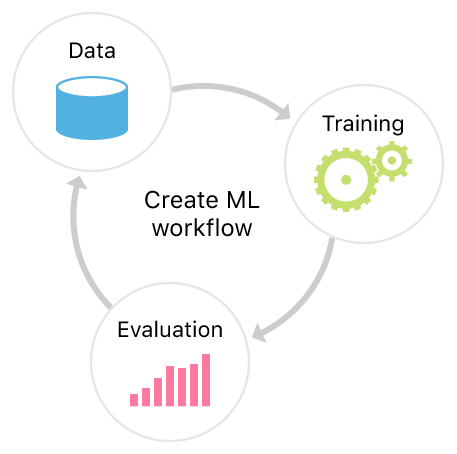


### Step 1. Load and Display the Well-log Datasets - TBU

* We had already created Xarrays from the LAS files during our "Data Loading" exercise. Let's load back these files and create dataframes from them.<br><br>
* To make things easier, we have chosen 4 wells for this exercise to analyze:<br> 
    * '15_9-F-11A'
    * '15_9-F-1A'
    * '15_9-F-1B'
    * '15_9-F-11T2'

In [ ]:
def well_log_plot(well,logs,colors):
  # create the subplots; ncols equals the number of logs
  fig, ax = plt.subplots(nrows=1, ncols=len(logs),sharey=True, figsize=(20,10))
  # looping each log to display in the subplots
  for i in range(len(logs)):
    if i == 3:
      # for resistivity, semilog plot
      ax[i].semilogx(well[logs[i]], well['DEPTH'], color=colors[i])
    else:
      # for non-resistivity, normal plot
      ax[i].plot(well[logs[i]], well['DEPTH'], color=colors[i])
  
    ax[i].set_title(logs[i])
    ax[i].grid(True)

  plt.show()

*TBU - Change above function with well_log visualization function from Data Loading exercise*

In [ ]:
def load_las_xr_to_df(well_name: str, 
                      las_xr_dir: str):
    """
        Function to load well xarrays to a dataframe

        Args:
            well_name (str): the name of the well
            las_xr_dir (str): the location of the xarray files

        Returns:
            dataframe: the well data.
    """
    xr_list = os.listdir(las_xr_dir)                                    # Creating a list of all available xarray files
    file_to_load = [file for file in xr_list if well_name in file]      # Identify the file for the current well

    well_xr = xr.open_dataset(las_xr_dir + file_to_load[0])
    well_df = well_xr.to_dataframe()
    well_df.reset_index(inplace=True)
    return well_df


In [ ]:
wells_list  = ['15_9-F-11A',  '15_9-F-1A', '15_9-F-1B',  '15_9-F-11T2']
las_xr_dir = base_dir + '/loaded/'

wells = {}
for i in range(len(wells_list)):
    wells[i] = load_las_xr_to_df(well_name = wells_list[i], 
                                 las_xr_dir = las_xr_dir)

In [ ]:
# define what logs are we going to us
logs = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT','DTS']
colors = ['black', 'red', 'blue', 'green', 'purple', 'black', 'orange','brown']
well_log_plot(wells[0],logs,colors)

-----

### Step 2. Data Preparation

* For all supervised ML algorithms, we need to split the data into training and test sets. In some cases, there is also a blind validation set which is completely unseen by the model.

* The training of the model is strictly performed on the training dataset.

* We want our model to be 
    * Robust
    * Generalizable
    * Accurate in its predictions

* We do not want our model to 
    * Overfit the training data
    * Unable to identify the general trend

* It is an under-appreciated fact that the quality of your model is a direct result of how good your data is.<br><br>

**Remember: Bad data will produce a bad model!**

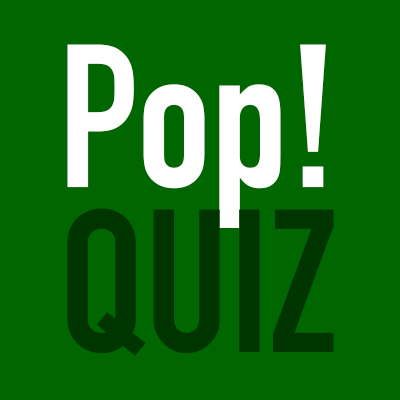

#### Pop Quiz

1.   **What is overfitting?**
2.   **How can we avoid it?**

* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 

















Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data.
Overfitting occurs when the model performs well on training data but generalizes poorly to unseen data. 



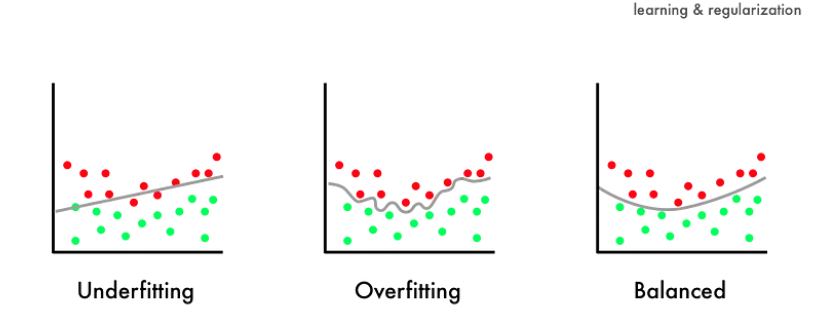


* Prevent Overfitting
1. Hold-out
2. Cross-validation
3. Data augmentation
4. Feature selection
5. Remove layers /number of units perlayer
6. Dropout
7. Early stopping




But first, let's define some helper functions which will be useful in our workflow.

In [ ]:
def rolling_window(curve, window_length, func1d, step=1, return_rolled=False):
        """
        Helper function. Smoother for other smoothing/conditioning functions.

        Args:
            window_length (int): the window length.
            func1d (function): a function that takes a 1D array and returns a
                scalar.
            step (int): if you want to skip samples in the shifted versions.
                Don't use this for smoothing, you will get strange results.

        Returns:
            ndarray: the resulting array.
        """
        # Force odd.
        if window_length % 2 == 0:
            window_length += 1

        shape = curve.shape[:-1] + (curve.shape[-1], window_length)
        strides = curve.strides + (step*curve.strides[-1],)
        data = np.nan_to_num(curve)
        data = np.pad(data, int(step*window_length//2), mode='edge')
        rolled = np.lib.stride_tricks.as_strided(data,
                                                 shape=shape,
                                                 strides=strides)
        result = np.apply_along_axis(func1d, -1, rolled)
        result[np.isnan(curve)] = np.nan

        if return_rolled:
            return result, rolled
        else:
            return result
            
def despike(curve, window_length=33, samples=True, z=2):
        """
        Function to remove spikes and spurious log data.
        
        Args:
            window (int): window length in samples. Default 33 (or 5 m for
                most curves sampled at 0.1524 m intervals).
            samples (bool): window length is in samples. Use False for a window
                length given in metres.
            z (float): Z score

        Returns:
            Curve.
        """
        window_length //= 1 if samples else curve.step
        z *= np.nanstd(curve)  # Transform to curve's units
        curve_sm = rolling_window(curve,window_length, np.median)
        spikes = np.where(np.nan_to_num(curve - curve_sm) > z)[0]
        spukes = np.where(np.nan_to_num(curve_sm - curve) > z)[0]
        out = np.copy(curve)
        out[spikes] = curve_sm[spikes] + z
        out[spukes] = curve_sm[spukes] - z
        return out




In [ ]:
def well_curve_despike(df=None,feature_names=None,window_length=33,z=1.5):
  dfi_despike=df
  for j in range(len(feature_names)):
    if feature_names[j] != 'DEPTH' :
      dfi_despike[feature_names[j]] = despike(np.array(dfi_despike[feature_names[j]]), window_length=window_length, samples=True, z=z)
  
  return dfi_despike

In [ ]:
def data_prep_for_model(df, 
                        cols: list, 
                        well_name: str):
    """
    Function to address NaNs, despike the data.
    """

    df = df[cols]

    #Delete points where data are missing 
    df_non_nan = df.dropna()
    df = df[(df['DEPTH']>=df_non_nan['DEPTH'].min()) & (df['DEPTH']<=df_non_nan['DEPTH'].max())] 
    
    #fill nan with nearest value
    #df.fillna(method='ffill',inplace=True)
    df.dropna(inplace=True)

    # transform the RT to logarithmic
    df['RT'] = np.log10(df['RT'])
    
    #despike curves
    df = well_curve_despike(df=df,feature_names=cols,window_length=50,z=2)

    #add well name column
    df['WELL']=well_name

    return df 

In [ ]:
# Define training columns to use
cols = ['DEPTH','NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT','DTS']

# Run data prep on all the dataframes
for i in range(len(wells_list)):
    wells[i]= data_prep_for_model(df = wells[i], cols=cols, well_name=wells_list[i])

In [ ]:
wells[1]

In [ ]:
# Merge Dataframes
well_train = pd.concat([wells[i] for i in range(len(wells_list) - 1)])
well_test = wells[len(wells_list) - 1]
wells_df = pd.concat([well_train, well_test],axis=0)


In [ ]:
# define what logs are we going to us
logs = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT','DTS']
colors = ['black', 'red', 'blue', 'green', 'purple', 'black', 'orange','brown']
well_log_plot(wells[0],logs,colors)

### Step 3. Exploratory Data Analysis (EDA)

It is extremely important to analyze & understand the data at hand before we run any models, or make any assumptions.<br>
EDA helps us identify errors, missing data, outliers, and find interesting relationships between the features.

#### Pairplot

* A Pairplot allows us to analyse pairwise relationships between variables within a dataset. 
* This provides greater insight into the data by summarising a large amount of data in a single figure. 

In [ ]:
train_features = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT','DTS']
sns.pairplot(well_train, vars=train_features, diag_kind='kde', plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

#### Spearman's correlation heatmap

*   Two variables are said to be positively correlated if one increases and the other increases too. In contrast, they are negatively correlated if the high values of one variable go with the low values of another variable.

In [ ]:
well_train_only_features = well_train[train_features]

# Correlation between different variables

corr = well_train_only_features.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

### Step 4. Normalization

*   Normalization is a transformation of features to bring them to a similar scale. This improves the performance of training, and makes the model more stable.

*   An important thing to remember is that if features have been normalised for the training data, the same normalization steps need to be applied on the test set.

*   Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data.

*   We shall use min-max scaling to constrain the range of the input and output. This would constrain the values between 0 & 1.<br> There are other normalization methods as well such as mean normalization (or standardization) etc.

*   Min-max scaling
        x_scaled = (x — x_min) / (x_max — x_min), where
        x_min → minimum value of a column<br>
        x_max → maximum value of a column

In [ ]:
# Importing relevant libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

In [ ]:

only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = ['DT','DTS'] # only target column names

#scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

x=well_train[only_feature].copy()
y=well_train[only_target].copy()

# Creating scaled training set
X_train = scaler_X.fit_transform(x.values)
y_train = scaler_y.fit_transform(y.values)

X_test=well_test[only_feature].copy()
y_test=well_test[only_target].copy()

# Creating scaled test set
X_test = scaler_X.transform(X_test.values)
y_test = scaler_y.transform(y_test.values)

In [ ]:
# Define the test data 
def well_x_y_normalisation(wells_df=None,
                           well_name:str=None):
  
  # split the dataframe with respect to its name
  test = wells_df.loc[wells_df['WELL'] == well_name]

  # Drop well name column, since it is not a feature
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature) and y_test (target)
  X_test_, y_test_ = test[only_feature].values, test[only_target].values
  X_test_ = scaler_X.transform(X_test_)
  y_test_ = scaler_y.transform(y_test_)
  
  return X_test_,y_test_



In [ ]:
wells_df = pd.concat([well_train,well_test],axis=0)

X_test1,y_test1=well_x_y_normalisation(wells_df=wells_df,well_name=well_name)
X_test2,y_test2=well_x_y_normalisation(wells_df=wells_df,well_name=wells_list[1])
X_test3,y_test3=well_x_y_normalisation(wells_df=wells_df,well_name=wells_list[2])
X_test4,y_test4=well_x_y_normalisation(wells_df=wells_df,well_name=wells_list[3])

### Step 5. Training 

We shall train a relatively shallow neural network using tensorflow / keras. <br><br>

Speaking of training, there is a plethora of training material out there for ML applications in pretty much all fields of work. <br>

Pro Tip: Our suggestion is that once you feel comfortable with basic coding process of ML algorithms, try to implement them to new and unique problems.<br>
There are only so many houses whose prices you can predict. Don't stop at that.

#### Feed-forward Neural Networks

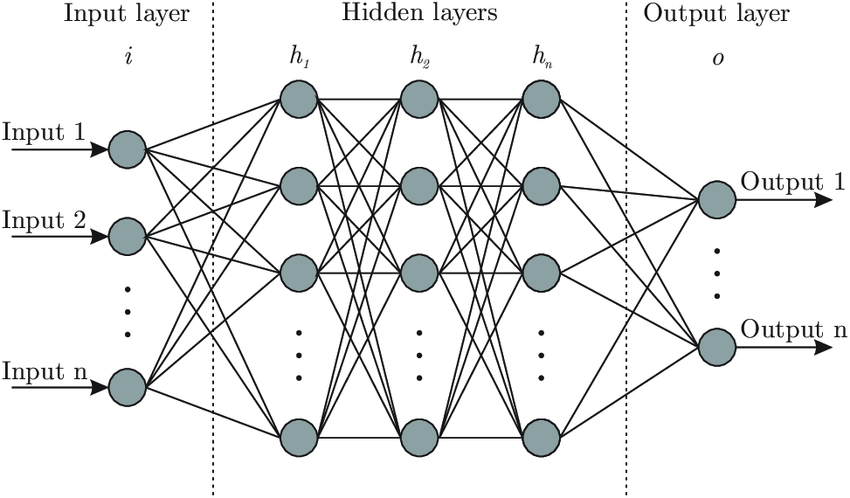

* Feed-Forward Neural Networks, also known as Sequential models, consist of an input layer, an output layer, with hidden layers stacked in between.<br>
* The information propagates from the input to the output through hidden layers. 
* Every interconnection in the neural network has a 'weight' associated with it, and every neuron has a 'bias' associated with it.
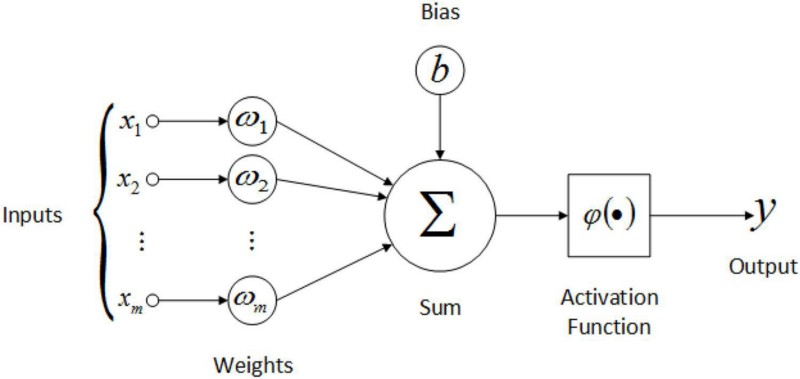
* The training task is to compute the optimal weights and biases by minimizing some cost function. This feedback only happens at the output layer.
* Gradients are calculated for each layer of the network and these are 'backpropagated' through the layers, from the output layer back into the network. The weights for each neuron are updated using these gradients.

<br>



*  What is an Activation Function?<br>
An activation function allows the network to learn complex patterns in the data. 
When comparing with a neuron-based model that is in our brains, the activation function is at the end deciding what is to be fired to the next neuron. All neurons in a particular layer use the same activation function.<br>
Some common activation functions are below:
    * ReLU:      max(0.0, x)
    * TanH:     (e^x – e^-x) / (e^x + e^-x)
    * Sigmoid:   1.0 / (1.0 + e^-x)
    * Leaky ReLU: max(0.01*x , x)
    
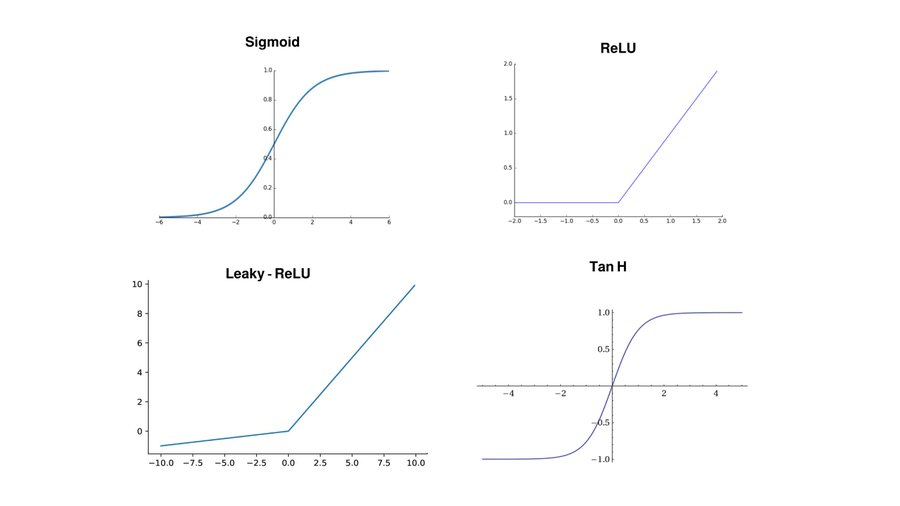
List of common activation functions
https://www.tensorflow.org/api_docs/python/tf/keras/activations


**For Bonus points**<br>
What is an optimizer? 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* Optimizer tie together the loss function and model parameters by updating the model in response to the output of the loss function. 
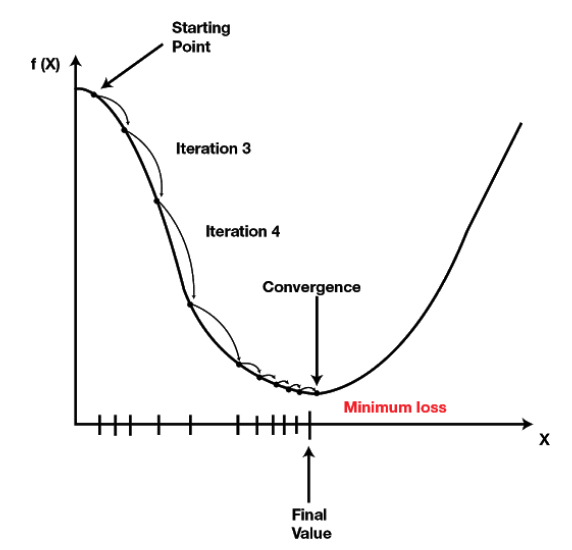

#### Training a Neural Network

In [ ]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.callbacks import EarlyStopping
#model 
 

save_model_name=base_dir+'/workshop_data/model_trained/sonic_pred.hdf5'
adam = optimizers.Adam(lr=0.0005)
#model.compile(

#model_checkpoint = ModelCheckpoint(
#https://keras.io/api/callbacks/model_checkpoint/

#earlystop = EarlyStopping(
#https://keras.io/api/callbacks/early_stopping/

# Fit the regressor to the training data
#hist = model.fit( X_train, y_train, batch_size=5, epochs=50, callbacks=[model_checkpoint,earlystop], validation_data=(X_test, y_test))


In [ ]:
    plt.figure(figsize=(8,5))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### Step 6: Predictions

In [ ]:
# Import the metrics you would like to use to evaluate the model
from sklearn.metrics import r2_score, mean_squared_error 

def model_prediction(X_test=None,y_test=None,model=None):
  # Predict on test well
  y_pred = model.predict(X_test)
  print("R-squared: {}".format(r2_score(y_pred, y_test)))
  
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  print("RMSE: {}".format(rmse))
  print()
  return y_pred


In [ ]:
from keras.models import load_model
model=load_model(save_model_name)
y_pred1 = model_prediction(X_test=X_test1, y_test=y_test1, model=model)
y_pred2 = model_prediction(X_test=X_test2, y_test=y_test2, model=model)
y_pred3 = model_prediction(X_test=X_test3, y_test=y_test3, model=model)
y_pred4 = model_prediction(X_test=X_test4, y_test=y_test4, model=model)

### Step 7: check_predictions 

It is always important to evaluate the predictions we have made on test data. This allows us to have confidence in the model before we apply it on true blind validation data, whose predicted value we do not know.

In [ ]:
# Compute estimations:
#denormalisation
y_true = scaler_y.inverse_transform(y_test4)
y_pred = scaler_y.inverse_transform(y_pred4)

In [ ]:
def qc_cross_plot(y_true=None,y_pred=None):
  # Plot results:
  plt.figure(figsize=(15,5))
  i = 0
  plt.subplot(1,2,i+1)
  plt.plot(y_true[:,i], y_pred[:,i], '.', label = 'r^2 = %.3f' % (r2_score(y_pred[:,i], y_true[:,i])))
  plt.plot([y_pred[:,i].min(),y_pred[:,i].max()],[y_pred[:,i].min(),y_pred[:,i].max()], 'r')
  plt.title('DTC')
  plt.xlabel('True')
  plt.ylabel('Estimate')
  plt.grid()
  plt.legend()
  i += 1
  plt.subplot(1,2,i+1)
  plt.plot(y_true[:,i], y_pred[:,i], '.', label = 'r^2 = %.3f' % (r2_score(y_pred[:,i], y_true[:,i])))
  plt.plot([y_pred[:,i].min(),y_pred[:,i].max()],[y_pred[:,i].min(),y_pred[:,i].max()], 'r')
  plt.title('DTS')
  plt.xlabel('True')
  plt.ylabel('Estimate')
  plt.grid()
  plt.legend()
  plt.show()

In [ ]:
qc_cross_plot(y_true=y_true,y_pred=y_pred)

In [ ]:
def qc_errors(y_true=None,y_pred=None):
  MSE_0 = mean_squared_error(y_true[:,0], y_pred[:,0]);
  RMSE_0 = np.sqrt(mean_squared_error(y_true[:,0], y_pred[:,0]));
  MSE_1 = mean_squared_error(y_true[:,1], y_pred[:,1]);
  RMSE_1 = np.sqrt(mean_squared_error(y_true[:,1], y_pred[:,1]));
  print('RMSE of test data (#1 DTC): %.2f' %(RMSE_0))
  print('RMSE of test data (#2 DTS): %.2f' %(RMSE_1))
  print('Overall RMSE = %.2f' %np.sqrt((MSE_0+MSE_1)/2))

In [ ]:
qc_errors(y_true=y_true,y_pred=y_pred)

In [ ]:
def qc_prediction_curve_plot(y_true=None,y_pred=None,well_test=None):
  well_test['DT_predicted']=y_pred[:,0]
  well_test['DTS_predicted']=y_pred[:,1]
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,20))
  i = 0
  ax[i].plot(well_test['DT'],well_test['DEPTH'],label='True')
  ax[i].plot(well_test['DT_predicted'],well_test['DEPTH'],linewidth=2,label='Predicted')
  ax[i].set_ylabel('Depth')
  ax[i].set_xlabel('DTC')
  ax[i].invert_yaxis()
  ax[i].set_title('DTC Prediction')
  ax[i].grid(True)
  i += 1
  ax[i].plot(well_test['DTS'],well_test['DEPTH'],label='True')
  ax[i].plot(well_test['DTS_predicted'],well_test['DEPTH'],linewidth=2,label='Predicted')
  ax[i].legend()
  ax[i].set_ylabel('Depth')
  ax[i].set_xlabel('DTS')
  ax[i].invert_yaxis()
  ax[i].set_title('DTS Prediction ')
  ax[i].grid(True)
  plt.show()

In [ ]:
qc_prediction_curve_plot(y_true=y_true,y_pred=y_pred,well_test=well_test)

### Conclusions

* The predicted logs bear a close resemblance to the true sonic logs.
* Different ML algorithms can be applied on the data. Some may perform better than others, depending on the parameters used, the abundance of data available, etc.
